In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


In [2]:
df = pd.read_csv(
    "data.csv",
    encoding="latin1",
    engine="python",
    on_bad_lines="skip"
)

# Extract NO2 feature
x = df["no2"].dropna().values.astype(np.float32)

In [3]:
r = 102303838  # your roll number

a_r = 0.5 * (r % 7)          # = 3.0
b_r = 0.3 * ((r % 5) + 1)    # = 1.2

z = x + a_r * np.sin(b_r * x)

# Normalize for GAN stability
z = (z - z.mean()) / z.std()

# Convert to torch tensor
z_real = torch.tensor(z).view(-1, 1)
print(a_r,b_r)


0.0 1.2


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

G = Generator()
D = Discriminator()

loss_fn = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=0.001)
opt_D = torch.optim.Adam(D.parameters(), lr=0.001)

In [5]:
epochs = 3000
batch_size = 64

for epoch in range(epochs):
    idx = np.random.randint(0, len(z_real), batch_size)
    real = z_real[idx]

    # Train Discriminator
    noise = torch.randn(batch_size, 1)
    fake = G(noise)

    D_real = D(real)
    D_fake = D(fake.detach())

    loss_D = loss_fn(D_real, torch.ones_like(D_real)) + \
             loss_fn(D_fake, torch.zeros_like(D_fake))

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    # Train Generator
    D_fake = D(fake)
    loss_G = loss_fn(D_fake, torch.ones_like(D_fake))

    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

Epoch 0 | Loss D: 1.4046 | Loss G: 0.5662
Epoch 500 | Loss D: 1.0653 | Loss G: 0.9242
Epoch 1000 | Loss D: 1.4222 | Loss G: 0.6393
Epoch 1500 | Loss D: 1.4039 | Loss G: 0.6861
Epoch 2000 | Loss D: 1.4197 | Loss G: 0.6198
Epoch 2500 | Loss D: 1.3772 | Loss G: 0.6588


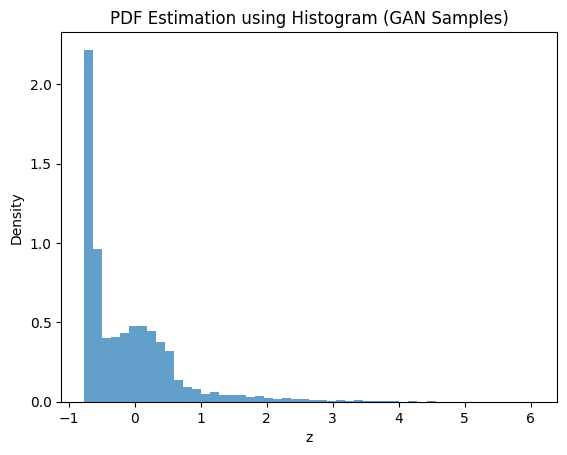

In [6]:
G.eval()
with torch.no_grad():
    z_f = G(torch.randn(10000, 1)).numpy().flatten()

# Histogram PDF
plt.figure()
plt.hist(z_f, bins=50, density=True, alpha=0.7)
plt.title("PDF Estimation using Histogram (GAN Samples)")
plt.xlabel("z")
plt.ylabel("Density")
plt.show()

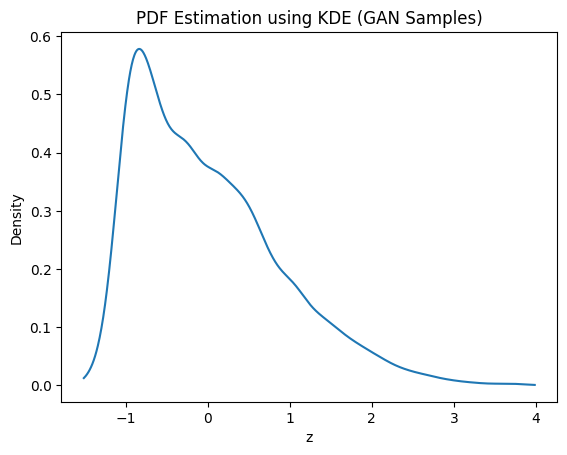

In [7]:
kde = gaussian_kde(z_f)
z_grid = np.linspace(z_f.min(), z_f.max(), 1000)

plt.figure()
plt.plot(z_grid, kde(z_grid))
plt.title("PDF Estimation using KDE (GAN Samples)")
plt.xlabel("z")
plt.ylabel("Density")
plt.show()

In [8]:
print("Transformation parameters:")
print("a_r =", a_r)
print("b_r =", b_r)


Transformation parameters:
a_r = 0.0
b_r = 1.2
